In [1]:
%load_ext autoreload
%autoreload 2

curr_dir = '/user_data/vayzenbe/GitHub_Repos/goodale-milner-dnns'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys


sys.path.append('DeepDive')
sys.path.append('CORnet')
from deepdive.feature_extraction import get_empty_feature_maps, StimulusSet, get_all_feature_maps



import cornet

import torch

import torch.nn as nn
import torchvision
from torchvision.models import resnet18, alexnet, vgg19, vgg11


from sklearn.model_selection import StratifiedShuffleSplit

from sklearn import svm

import warnings

from tqdm import tqdm
import itertools
warnings.filterwarnings('ignore')


/home/vayzenbe/anaconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_suf = ''

splits = 15


transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(224),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                 std=[0.5, 0.5, 0.5]),
#                 torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225])
            ])

models = ['alexnet','vgg19','resnet18','cornet_z','cornet_s']

In [3]:
def load_model(model_arch):   
    if model_arch =='cornet_z':
        model = cornet.get_model('z', pretrained=True, map_location=torch.device('cpu')).module

    elif model_arch =='cornet_s':
        model = cornet.get_model('s', pretrained=True, map_location=torch.device('cpu')).module

    elif model_arch =='alexnet':
        model = alexnet(pretrained=True)

    elif model_arch =='vgg19':
        model = vgg19(pretrained=True)

    elif model_arch =='resnet18':
        model = resnet18(pretrained=True)
        
    return model

In [4]:
def get_loader(stim_dir):
    test_dataset =torchvision.datasets.ImageFolder(stim_dir, transform=transform)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers = 2, pin_memory=True)
    return testloader, test_dataset


In [7]:
from sklearn.linear_model import LogisticRegression
def get_label_match_mat(labels):
    label_mat = np.zeros((len(labels), len(labels)), dtype=bool)
    for ii, label1 in enumerate(labels):
        for jj, label2 in enumerate(labels):
            label_mat[ii,jj] = label1 == label2
    return label_mat

def prep_similarities(X, y):
    sims = np.corrcoef(X)
    trili = np.tril_indices(sims.shape[0], k=-1)
    label_mat = get_label_match_mat(y)
    samediff = label_mat[trili]
    return sims[trili], samediff

def similarity_based_2way_classify(acts, labels, splits=3):
    acc = []
    for label_pair in itertools.combinations(np.unique(labels), 2):
        sss = StratifiedShuffleSplit(n_splits=splits, test_size=0.33)
        inds = np.argwhere([label in label_pair for label in labels]).squeeze()
        acts_ = acts[inds]
        labels_ = labels[inds]
        sim, samediff = prep_similarities(acts_, labels_)
        for i, (train_index, test_index) in enumerate(sss.split(sim, samediff)):
            X_train, X_test = sim[train_index], sim[test_index]
            y_train, y_test = samediff[train_index], samediff[test_index]
            
            clf = LogisticRegression(penalty='none')
            clf.fit(X_train.reshape(-1,1), y_train)
            this_acc = clf.score(X_test.reshape(-1,1), y_test)
            acc.append(this_acc)

    return np.array(acc)

In [8]:
# get RSA d-prime between same/different

model_df = dict(model=[], layer=[], accuracy=[], experiment=[])
for experiment in ['rect_orient', 'curv_orient']:
    testloader, test_dataset = get_loader(f'{curr_dir}/stim/{experiment}')
    labels = torch.cat([labels for inputs, labels in testloader]).numpy()
    cat_num = len(test_dataset.classes)

    # model_df = pd.DataFrame(columns = models)
    for model_arch in tqdm(models):
        model = load_model(model_arch)
        model_layers = get_empty_feature_maps(model, testloader, names_only = True)
        # in general let's just use the ReLU layers, but also the average pooling over space that occurs in ResNet and CORnet models without rectifcation before the classifier
        layers = [layer for layer in model_layers if 'ReLU' in layer or 'AdaptiveAvgPool2d-1' in layer]
        model.to('cuda')
        activations = get_all_feature_maps(model, testloader, layers_to_retain=layers)

        for layer in layers:
            accs = similarity_based_2way_classify(activations[layer], labels)
            for acc in accs:
                model_df['model'].append(model_arch)
                model_df['layer'].append(layer)
                model_df['accuracy'].append(acc)
                model_df['experiment'].append(experiment)

100%|██████████| 5/5 [00:47<00:00,  9.44s/it]


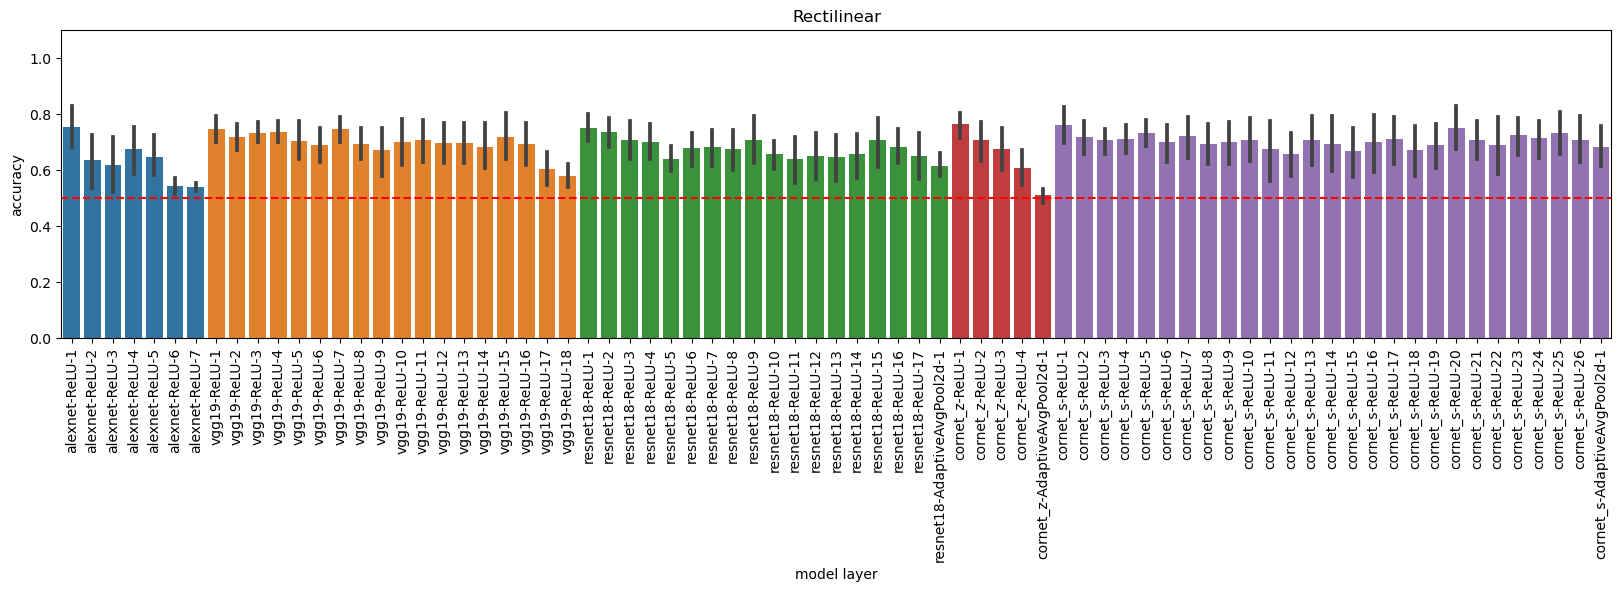

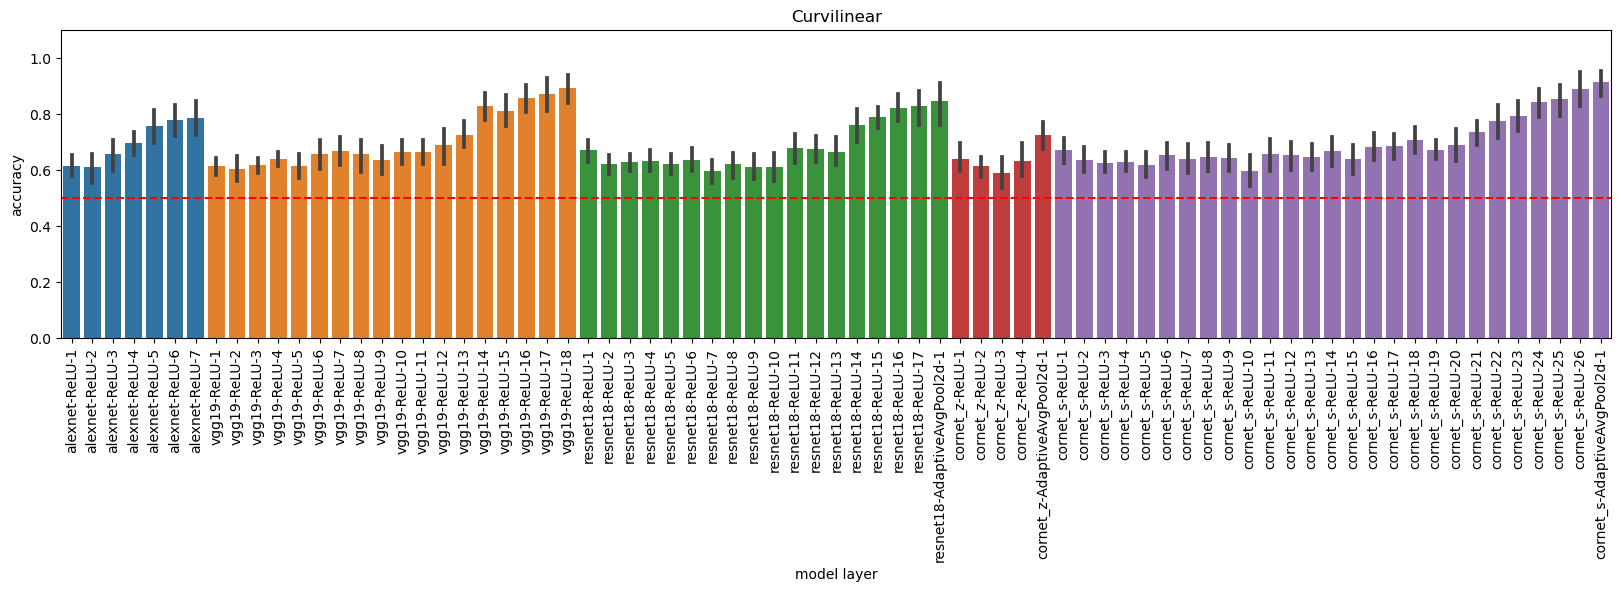

In [10]:
model_df = pd.DataFrame(model_df)
model_df['model layer'] = model_df['model'] + '-' +  model_df['layer']
for experiment, name in zip(['rect_orient', 'curv_orient'], ['Rectilinear', 'Curvilinear']):
    fig = plt.figure(figsize=(20,4))
    g = sns.barplot(data=model_df[model_df.experiment == experiment], x='model layer', y='accuracy', hue='model', dodge=False)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.title(name)
    plt.legend().remove()
    plt.ylim(0, 1.1)
    g.axhline(y=0.5, color='r', linestyle='--')
    #plt.savefig(f'figures/{experiment}_allmodels_rsa_accuracy.png', dpi=200, bbox_inches='tight')
    plt.show()

In [ ]:
# get RSA d-prime between same/different

model_df = dict(model=[], layer=[], accuracy=[], experiment=[])
for experiment in ['rect_scale', 'curv_scale']:
    testloader, test_dataset = get_loader(f'{curr_dir}/stim/{experiment}')
    labels = torch.cat([labels for inputs, labels in testloader]).numpy()
    cat_num = len(test_dataset.classes)

    # model_df = pd.DataFrame(columns = models)
    for model_arch in tqdm(models):
        model = load_model(model_arch)
        model_layers = get_empty_feature_maps(model, testloader, names_only = True)
        # in general let's just use the ReLU layers, but also the average pooling over space that occurs in ResNet and CORnet models without rectifcation before the classifier
        layers = [layer for layer in model_layers if 'ReLU' in layer or 'AdaptiveAvgPool2d-1' in layer]
        model.to('cuda')
        activations = get_all_feature_maps(model, testloader, layers_to_retain=layers)

        for layer in layers:
            accs = similarity_based_2way_classify(activations[layer], labels)
            for acc in accs:
                model_df['model'].append(model_arch)
                model_df['layer'].append(layer)
                model_df['accuracy'].append(acc)
                model_df['experiment'].append(experiment)